## Training the Model

In [1]:
import os

import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms 
from sklearn import metrics, model_selection, preprocessing
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset 

from Model import *
from callbacks import EarlyStopping
from efficientnet_pytorch import EfficientNet
from utils import *

INPUT_PATH = "images/"
TRAIN_PATH = "images/train/"
VALID_PATH = "images/valid/"
MODEL_PATH = "models/"
MODEL_NAME = "EfficientNet_model_Changed_"
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 20
IMAGE_SIZE = 256

In [2]:
class LeafModel(Model):
    def __init__(self, num_classes, init=nn.init.kaiming_normal_):
        super().__init__()

        self.effnet = EfficientNet.from_pretrained("efficientnet-b3")
        self.head = create_head(1536, num_classes)

    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, outputs)
        return {"accuracy": accuracy}

    def fetch_optimizer(self):
        opt = torch.optim.Adam(self.parameters(), lr=3e-4)
        return opt

    def fetch_scheduler(self):
        sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1
        )
        return sch

    def forward(self, image, targets=None):
        batch_size, _, _, _ = image.shape

        x = self.effnet.extract_features(image)
        outputs = self.head(x)

        if targets is not None:
            loss = nn.CrossEntropyLoss()(outputs, targets)
            metrics = self.monitor_metrics(outputs, targets)
            return outputs, loss, metrics
        return outputs, None, None

In [52]:
train_aug = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation((-20, 20)),
                                transforms.RandomAffine(degrees=5, translate=(0.10, 0.15)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                transforms.RandomErasing(p=0.4)
                                ])
valid_aug = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

In [53]:
train_dataset = datasets.ImageFolder("images/train/", transform=train_aug)
valid_dataset = datasets.ImageFolder("images/valid/", transform=valid_aug)

In [5]:
train_dataset.classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper_bell___Bacterial_spot',
 'Pepper_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [6]:
 torch.cuda.current_device()

0

In [7]:
torch.cuda.get_device_name(0)

'GeForce RTX 3070'

In [18]:
model = LeafModel(num_classes=len(train_dataset.classes))

Loaded pretrained weights for efficientnet-b3


In [10]:
es = EarlyStopping(
        monitor="valid_loss",
        model_path=os.path.join(MODEL_PATH, MODEL_NAME + "_early.bin"),
        patience=3,
        mode="min")

In [11]:
model.fit(
        train_dataset,
        valid_dataset=valid_dataset,
        train_bs=TRAIN_BATCH_SIZE,
        valid_bs=VALID_BATCH_SIZE,
        device="cuda",
        epochs=EPOCHS,
        fp16=True,
        callbacks=[es])

100%|███████████████████████████████████████| 476/476 [00:35<00:00, 13.45it/s, accuracy=0.98, loss=0.0649, stage=Valid]


Validation score improved (inf --> 0.06492789004647528). Saving model!


100%|██████████████████████████████████████| 476/476 [00:36<00:00, 12.89it/s, accuracy=0.987, loss=0.0428, stage=Valid]


Validation score improved (0.06492789004647528 --> 0.04278222206799519). Saving model!


100%|███████████████████████████████████████| 476/476 [00:36<00:00, 13.03it/s, accuracy=0.99, loss=0.0333, stage=Valid]


Validation score improved (0.04278222206799519 --> 0.03327983659180174). Saving model!


100%|████████████████████████████████████████| 476/476 [00:35<00:00, 13.22it/s, accuracy=0.99, loss=0.031, stage=Valid]


Validation score improved (0.03327983659180174 --> 0.031012152878440967). Saving model!


100%|██████████████████████████████████████| 476/476 [00:36<00:00, 13.21it/s, accuracy=0.993, loss=0.0238, stage=Valid]


Validation score improved (0.031012152878440967 --> 0.023779844050050424). Saving model!


  0%|                                                                                         | 0/1905 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


100%|██████████████████████████████████████| 476/476 [00:36<00:00, 13.22it/s, accuracy=0.995, loss=0.0164, stage=Valid]


Validation score improved (0.023779844050050424 --> 0.01642550785172727). Saving model!


  0%|                                                                                         | 0/1905 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


100%|███████████████████████████████████████| 476/476 [00:36<00:00, 13.20it/s, accuracy=0.996, loss=0.014, stage=Valid]


Validation score improved (0.01642550785172727 --> 0.014034570244218076). Saving model!


  0%|                                                                                         | 0/1905 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


100%|██████████████████████████████████████| 476/476 [00:35<00:00, 13.26it/s, accuracy=0.996, loss=0.0112, stage=Valid]


Validation score improved (0.014034570244218076 --> 0.01122772588627208). Saving model!


  0%|                                                                                         | 0/1905 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


  0%|                                                                                         | 0/1905 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 3


100%|█████████████████████████████████████| 476/476 [00:35<00:00, 13.23it/s, accuracy=0.998, loss=0.00645, stage=Valid]


Validation score improved (0.01122772588627208 --> 0.0064530765620775). Saving model!


  0%|                                                                                         | 0/1905 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


  0%|                                                                                         | 0/1905 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 3


100%|█████████████████████████████████████| 476/476 [00:36<00:00, 13.21it/s, accuracy=0.998, loss=0.00798, stage=Valid]

EarlyStopping counter: 3 out of 3


In [10]:
model.save_model(os.path.join(MODEL_PATH, MODEL_NAME + "Final_onlyModel.pth"))

### Performace Matrics for Validation Dataset

In [3]:
model = LeafModel(num_classes=33)

Loaded pretrained weights for efficientnet-b3


In [4]:
model.load('models/EfficientNet_model_Changed_Final_onlyModel.pth')

In [5]:
valid_aug = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
valid_dataset = datasets.ImageFolder("images/valid/", transform=valid_aug)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score

In [7]:
valid_dataset

Dataset ImageFolder
    Number of datapoints: 15231
    Root location: images/valid/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
valid_dataloader = DataLoader(valid_dataset)

In [10]:
y_true = [int(label) for image, label in valid_dataloader]

In [12]:
y_True.shape

(15231,)

In [11]:
y_True = np.array(y_true)

In [8]:
y_pred, args = model.predict(valid_dataset, 'cuda')

100%|████████████████████████████████████████████████████████████████████| 952/952 [01:10<00:00, 13.55it/s, stage=Test]


In [18]:
print(classification_report(y_True, args))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       504
           1       1.00      1.00      1.00       497
           2       1.00      0.99      1.00       440
           3       1.00      1.00      1.00       502
           4       1.00      1.00      1.00       421
           5       1.00      1.00      1.00       456
           6       1.00      1.00      1.00       410
           7       0.99      1.00      1.00       477
           8       0.99      0.99      0.99       477
           9       1.00      1.00      1.00       465
          10       1.00      1.00      1.00       472
          11       1.00      1.00      1.00       480
          12       1.00      1.00      1.00       430
          13       1.00      1.00      1.00       423
          14       1.00      1.00      1.00       459
          15       1.00      1.00      1.00       432
          16       1.00      1.00      1.00       478
          17       1.00    

In [19]:
conMatrix = confusion_matrix(y_True, args)

In [48]:
classes = ['Apple -- Apple Scab',
    'Apple -- Black Rot',
    'Apple -- Cedar Apple Rust',
    'Apple -- Healthy',
    'Cherry -- Powdery Mildew',
    'Cherry --  Healthy',
    'Corn -- Gray Leaf Spot (Cercospora Leaf Spot)',
    'Corn -- Common Rust',
    'Corn -- Northern Leaf Blight',
    'Corn -- Healthy',
    'Grape -- Black Rot',
    'Grape -- Esca (Black Measles)',
    'Grape -- Leaf Blight (Isariopsis Leaf Spot)',
    'Grape -- Healthy',
    'Peach -- Bacterial_spot',
    'Peach -- Healthy',
    'Pepper Bell -- Bacterial Spot',
    'Pepper Bell -- Healthy',
    'Potato -- Early Blight',
    'Potato -- Late Blight',
    'Potato -- Healthy',
    'Strawberry -- Leaf Scorch',
    'Strawberry -- Healthy',
    'Tomato -- Bacterial Spot',
    'Tomato -- Early Blight',
    'Tomato -- Late Blight',
    'Tomato -- Leaf Mold',
    'Tomato -- Septoria Leaf Spot',
    'Tomato -- Two-spotted Spider Mites',
    'Tomato -- Target Spot',
    'Tomato -- Yellow Leaf Curl Virus',
    'Tomato -- Mosaic Virus',
    'Tomato -- Healthy']

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

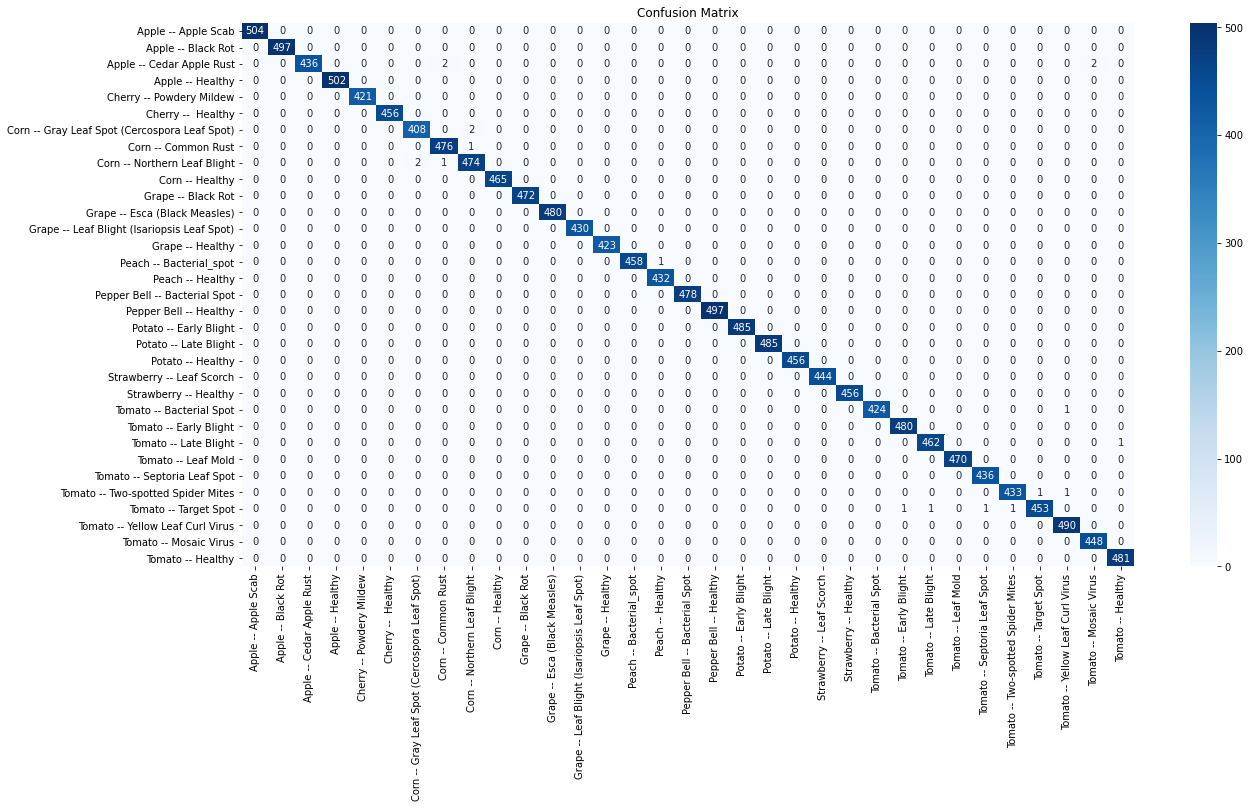

In [50]:
plt.figure(figsize=(20,10))
sns.heatmap(conMatrix, annot=True, fmt=".3g", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.savefig('HeatMap.png', bbox_inches = 'tight');

In [34]:
accuracy_score(y_True, args)

0.9987525441533714

In [157]:
recall_score(y_True, args, average='macro')

0.9987152558753591

In [158]:
precision_score(y_True, args, average='macro')

0.9987467273594998